## conditional-WGAN (Wasserstein Generative Adversarial Network) LDW examples

Wei Li

This illustration is a simplied and modified version based on the package https://ds-wgan.readthedocs.io/en/latest/

Credits: 
Susan Athey, Guido Imbens, Jonas Metzger, Evan Munro [2019]

In [1]:
import os
import torch
from torch import nn
from torch.utils import data
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
import random

# random_seed = 123
# os.environ["PL_GLOBAL_SEED"] = str(random_seed)
# random.seed(random_seed)
# np.random.seed(random_seed)

In [2]:
# %pip install watermark
%load_ext watermark
%watermark -a "Wei Li" -u -t -d -v -p numpy,torch

Author: Wei Li

Last updated: 2024-01-16 12:11:32

Python implementation: CPython
Python version       : 3.8.17
IPython version      : 8.12.2

numpy: 1.21.5
torch: 1.12.1



In [3]:
# From local helper files
from utils_evaluation import (
    set_all_seeds,
    set_deterministic,
    compare_dfs
)

from utils_data import preprocess, deprocess

In [4]:
## Setting 
RANDOM_SEED = 2022
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
set_all_seeds(RANDOM_SEED)
set_deterministic()

### Data

This is data on a job training program (the treatment) that was intended to raise
future earnings (the outcome). The income in $\$1000$ in the year of 1978. The data combines the original experimental data (445 observations) and additional control observations from PSID data, totalling $2675$ observations.


\begin{align*}
%\begin{array}{ll}
\hline \text { Variable } & \text { Description } \\
\hline \text { age } & \text { Age in years } \\
\text { educ } & \text { Years of education } \\
\text { black } & 1=\text { Black; } 0 \text { otherwise } \\
\text { hisp } & 1=\text { Hispanic; } 0 \text { otherwise } \\
\text { married } & 1=\text { married; } 0 \text { otherwise } \\
\text { nodegr } & 1=\text { no degree; } 0 \text { otherwise } \\
\text { re74 } & 1974 \text { income}\\
\text { re75 } & 1975 \text { income}  \\
\text { re78 } & 1978 \text { income} \\
\text { treat } & 1=\text { received treatment; } 0 \text { otherwise } \\
\hline
%\end{array}
\end{align*}


In [5]:
data_all = pd.read_csv("../data/psid_LDW_merged.csv").drop(["u74", "u75"], axis=1)

In [6]:
data_all.head()

,T,age,educ,black,hisp,married,nodegr,re74,re75,re78
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [7]:
# stats for treatment
print(data_all.describe())
print()

np.bincount(data_all["T"]), np.bincount(data_all["re78"] > 0)
# counts of 0/1
# (array([2490,  185]), array([ 331, 2344]))
# about 7% enrolled in the training program
# about 13% unemployed in 1978

                 T          age         educ        black         hisp  \
count  2675.000000  2675.000000  2675.000000  2675.000000  2675.000000   
mean      0.069159    34.225794    11.994393     0.291589     0.034393   
std       0.253772    10.499842     3.053556     0.454579     0.182269   
min       0.000000    17.000000     0.000000     0.000000     0.000000   
25%       0.000000    25.000000    10.000000     0.000000     0.000000   
50%       0.000000    32.000000    12.000000     0.000000     0.000000   
75%       0.000000    43.500000    14.000000     1.000000     0.000000   
max       1.000000    55.000000    17.000000     1.000000     1.000000   

           married       nodegr           re74           re75           re78  
count  2675.000000  2675.000000    2675.000000    2675.000000    2675.000000  
mean      0.819439     0.333084   18230.003096   17850.893766   20502.375641  
std       0.384726     0.471404   13722.251526   13877.777180   15632.519749  
min       0.00000

(array([2490,  185]), array([ 331, 2344]))

We shall consider generating variables $X$=("age", "educ", "re74", "re75", "re78"), based on the treatment status. We use Wasserstein GAN with gradient penalty to achieve this task.
This exercise contains two stages:

1. Train conditional GAN based on a balanced data `data_balanced`.
2. Generate X given T based on the `data_all` using the trained GAN from 1.

The dataframe `data_balanced` is obtained by sampling treated and controls with similar probability from `data_all`. We will train a WGAN on `data_balanced`, which makes sure the quality of the generated outcomes is similar for both treatment groups.

In [8]:
data_balanced = data_all.sample(
    2 * len(data_all),
    weights=(1 - data_all["T"].mean()) * data_all["T"]
    + data_all["T"].mean() * (1 - data_all["T"]),
    replace=True,
)  # balanced df for training

data_all.shape, data_balanced.shape

((2675, 10), (5350, 10))

<AxesSubplot: >

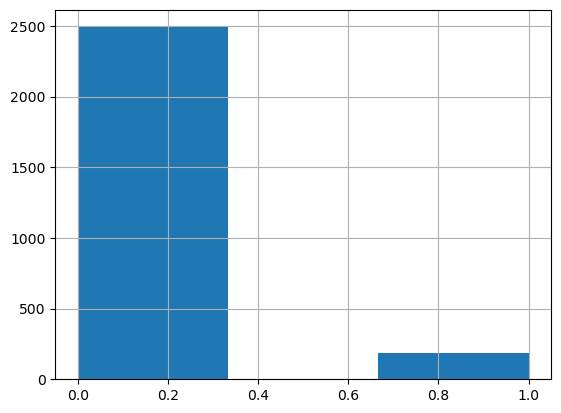

In [9]:
data_all["T"].hist(bins=3)

<AxesSubplot: >

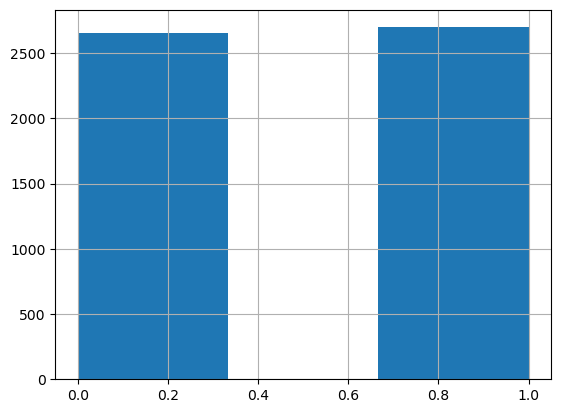

In [10]:
data_balanced["T"].hist(bins=3)

### Model


In [11]:
# X | t
continuous_vars = ["age", "educ", "re74", "re75", "re78"]
continuous_lower_bounds = {"age": 17, "educ": 0, "re74": 0, "re75": 0, "re78": 0}
continuous_upper_bounds = dict()  # none
categorical_vars = ["black", "hisp", "married", "nodegr"]
context_vars = ["T"]

variables = dict(
    continuous=continuous_vars,
    categorical=categorical_vars,
    context=context_vars,
)

cat_dims = [2, 2, 2, 2]  # List of dimension (number of levels) of each categorical variable
d_context = 1  # number of context variables
d_cont = 5  # number of continuous variables
d_x = 5 + 8
# d_x: (output dim) total number of continuous variables+ numer of variables (total levels) in the dummy categorical matrix
generator_d_noise = d_x  # (output dim)  total dim of continous and categorical levels

Our generator shall take in normalized dataset during the training process. Specifically,

It takes variables to be generated:
1. if continuous, then normalized
2. if categorical, then transformed to be one-hot encoding

It takes context variables:
1. if continuous, then normalized
2. if categorical, then coerced to be continous and normalized

When generating the data, we shall take transformed data as input for the trained generator, then de-transform the output.

In [12]:
continuous, context = [
    torch.tensor(np.array(data_balanced[variables[_]])).to(torch.float)
    for _ in ("continuous", "context")
]
# create continuous, and context variables as torch.tensor from the data_balanced
# both continuous and context are returned as tensor matrix, each shape (N, features)

# treat all context variables as continuous variables for normalization
cont_means = [x.mean(0, keepdim=True) for x in (continuous, context)]
# torch.mean compute the mean along 0 axis, output is a list of two lists
# first list stores means for continous variable, second list for context variable

cont_stds = [x.std(0, keepdim=True) + 1e-5 for x in (continuous, context)]

cat_labels = [
    torch.tensor(pd.get_dummies(data_balanced[v]).columns.to_numpy()).to(torch.float)
    for v in variables["categorical"]
]
# cat_labels: A list of tensors, where each tensor contains the
# labels of the levels of a categorical variable, represented as floating-point numbers.
# e.g. 
# for a categorical variable having 3 (numeric) levels, 5, 6, 7, pd.get_dummies(df[v]).columns.to_numpy()
# will return np.array [5, 6, 7]
# so cat_labels[0] gives tensor([5., 6., 7.]) the numerical label for this categorical variable


cont_bounds = [
    [
        continuous_lower_bounds[v] if v in continuous_lower_bounds.keys() else -1e8
        for v in continuous_vars
    ],
    [
        continuous_upper_bounds[v] if v in continuous_upper_bounds.keys() else 1e8
        for v in continuous_vars
    ],
]

cont_bounds = (torch.tensor(cont_bounds).to(torch.float) - cont_means[0]) / cont_stds[0]
# cont_bounds: torch.tensor
#     formatted lower and upper bounds of continuous variables
#     (formatted by normalizing the bounds by mean, and stds)
#     a tensor of size 2 by the number of continuous variables,

In [13]:
critic_d_hidden = [128, 128, 128]
critic_dropout = 0
critic_steps = (
    15  # Number of critic training steps taken for each generator training step
)
critic_lr = 1e-3
critic_gp_factor = 5 # gradient penalty weight

generator_d_hidden = [128, 128, 128]
generator_dropout = 0.1
generator_lr = 1e-3

max_epochs = 1000
batch_size = 32
test_set_size = 200
save_every = 100
print_every = 200
load_checkpoint = None
save_checkpoint = None
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
class Generator(nn.Module):
    """
    torch.nn.Module class for generator network in WGAN

    Generator is multi-layer FNN outputing logits.
    Then on the logits:
        for categorical variables: do a softmax.
        for continuous variables: simply taking the final values output from
        last hidden layer by truncating by the lower/upper bounds.

    Attrs:
        cont_bounds: torch.tensor
            formatted lower and upper bounds of continuous variables
            (i.e. normalized)
        cat_dims: list
            Dimension of levels for each categorical variable
        d_cont: int
            Total dimension of continuous variables
        d_cat: int
            Total dimension of categorical variables
        d_noise: int
            Dimension of noise input to generator
        layers: torch.nn.ModuleList
            Dense neural network layers making up the generator
        dropout: torch.nn.Dropout
            Dropout layer

    """

    def __init__(self):
        super().__init__()
        self.cont_bounds = cont_bounds
        self.cat_dims = cat_dims
        self.d_cont = self.cont_bounds.size(-1)  # dim of continuous variables
        self.d_cat = sum(cat_dims)  # dim of categorical levels
        self.d_noise = generator_d_noise
        # dim of the noise:
        # Default sets to the output dimension of the generator
        # (output dim, i.e., total dim of continous and categorical levels)

        d_in = [self.d_noise + d_context] + generator_d_hidden
        # d_in: =a list of input dimension in each layer
        # the input size of 1st layer is the total dim of (both continuous, categorical levels
        # and the context variables)

        d_out = generator_d_hidden + [self.d_cont + self.d_cat]
        # d_out: =a list of output dimension in each layer

        self.layers = nn.ModuleList([nn.Linear(i, o) for i, o in zip(d_in, d_out)])
        # e.g., four hidden layer, then
        # it returns like (input dim, 128),(128, 128), (128, 128) and (128, output dim)

        self.dropout = nn.Dropout(generator_dropout)

    def _transform(self, hidden):
        # This function is only used in the output layer
        # for categorical variables: do a softmax.
        # for continuous variables: simply taking the final values output from
        # last hidden layer by truncating by the lower/upper bounds.

        continuous, categorical = hidden.split([self.d_cont, self.d_cat], -1)

        if continuous.size(-1) > 0:  # apply bounds to continuous
            bounds = self.cont_bounds.to(hidden.device)
            continuous = (
                torch.stack([continuous, bounds[0:1].expand_as(continuous)])
                .max(0)
                .values
            )
            continuous = (
                torch.stack([continuous, bounds[1:2].expand_as(continuous)])
                .min(0)
                .values
            )

            # continuos is sample size by the number of continuous variables
            # now it contains the trimmed values according to the lower and upper bound

        if categorical.size(-1) > 0:  # renormalize categorical
            # for categorical variable, we convert the catergorical levels matrix
            # to probability distribution using softmax

            categorical = torch.cat(
                [F.softmax(x, -1) for x in categorical.split(self.cat_dims, -1)], -1
            )
            # categorical has size= sample size by number of all categorical levels
            # (if each categorical variable takes only 2 levels, then
            # number of all categorical levels= 2* number of categorical variables)
            # the entries for all the levels of the same categorical variable sum up to 1

        return torch.cat([continuous, categorical], -1)
        # the final return is a tensor of size =
        # sample size by (total number of continuous variables + number of all categorical levels)

    def forward(self, context):
        """
        Run generator model

        Args
            context: torch.tensor
                Variables to condition on

        Returns:
            torch.tensor (sample size, dim of output)
        """
        noise = torch.randn(context.size(0), self.d_noise).to(context.device)
        # noise size = sample size by output dimension of the generator

        x = torch.cat([noise, context], -1)
        # the input size is output dimension+ the dimension of the context
        # the noise is the input noise in the generator

        for layer in self.layers[:-1]:
            # from input layer to the last layer before output layer
            x = self.dropout(F.relu(layer(x)))

        # the x returned in the last for loop will be
        # dim= (sample size, dim of output)
        return self._transform(self.layers[-1](x))

In [15]:
class Critic(nn.Module):
    """
    torch.nn.Module for critic in WGAN framework

    Attrs:
        layers: torch.nn.ModuleList
            Dense neural network making up the critic
        dropout: torch.nn.Dropout
            Dropout layer applied between each of hidden layers

    """

    def __init__(self):
        super().__init__()
        d_in = [d_x + d_context] + critic_d_hidden
        d_out = critic_d_hidden + [
            1
        ]  # add one because output layer has one output
        self.layers = nn.ModuleList([nn.Linear(i, o) for i, o in zip(d_in, d_out)])

        self.dropout = nn.Dropout(critic_dropout)

    def forward(self, x, context):
        """
        Run critic model
        output logits (univariate)

        Args:
            x: torch.tensor
                Real or generated data
            context: torch.tensor
                Data conditioned on

        Returns:
            torch.tensor shape (sample size)
        """

        x = torch.cat([x, context], -1)
        for layer in self.layers[:-1]:
            x = self.dropout(F.relu(layer(x)))

        # The output will be just one scalar value for each data example
        return self.layers[-1](x)

    def gradient_penalty(self, x, x_hat, context):
        """
        Calculate gradient penalty

        Args:
            x: torch.tensor
                real data
            x_hat: torch.tensor
                generated data
            context: torch.tensor
                context data

        Returns:
            torch.tensor
        """

        alpha = torch.rand(x.size(0)).unsqueeze(1).to(x.device)
        interpolated = x * alpha + x_hat * (1 - alpha)
        interpolated = torch.autograd.Variable(
            interpolated.detach(), requires_grad=True
        )
        # the combination of detach() and requires_grad=True allows us to
        # reset the gradient computation history for interpolated. We detach it
        # from its history (to ignore gradients with respect to the original x and x_hat generation)
        # and then specify that we want to track gradients for future operations involving the interpolated tensor.

        critic = self(interpolated, context)
        # similar to calling of critic.forward(interpolated, context)

        gradients = torch.autograd.grad(
            critic,
            interpolated,
            torch.ones_like(critic),
            retain_graph=True,
            create_graph=True,
            only_inputs=True,
        )[0]

        penalty = F.relu(gradients.norm(2, dim=1) - 1).mean()  # one-sided

        return penalty

In [16]:
generator = Generator()
critic = Critic()

opt_generator = torch.optim.Adam(generator.parameters(), lr=generator_lr)
opt_critic = torch.optim.Adam(critic.parameters(), lr=critic_lr)

### Training

In [17]:
def train(generator, critic, x, context, device, penalty=None):
    """
    Function for training generator and critic in conditional WGAN-GP

    Args:
        generator: Generator network to be trained
        critic: Critic network to be trained
        x: torch.tensor
            Training data for generated data
        context: torch.tensor
            Data conditioned on for generating data
        penalty: an optional penalty for generator (not the gradient penalty)
    """
    # setup training objects

    start_epoch, step, description, device, t = 0, 1, "", device, time()

    generator.to(device), critic.to(device)

    # load data
    train_batches, test_batches = data.random_split(
        data.TensorDataset(x, context),
        (x.size(0) - test_set_size, test_set_size),
    )
    # train_batches[i] gives a tuple for the i-th example consisting of two elements,
    # one is from x, the other one is from context.

    train_batches, test_batches = (
        data.DataLoader(d, batch_size, shuffle=True)
        for d in (train_batches, test_batches)
    )

    # load checkpoints
    if load_checkpoint:
        # load_checkpoint: Filepath to existing model weights to start training from.
        cp = torch.load(load_checkpoint)
        generator.load_state_dict(cp["generator_state_dict"])
        opt_generator.load_state_dict(cp["opt_generator_state_dict"])
        critic.load_state_dict(cp["critic_state_dict"])
        opt_critic.load_state_dict(cp["opt_critic_state_dict"])
        start_epoch, step = cp["epoch"], cp["step"]
        #  step refers to each iteration for minibatch

    # start training
    try:
        for epoch in range(start_epoch, max_epochs):
            # train loop
            WD_train, n_batches = 0, 0
            # WD_train stores average WD-distance per epoch over minibatches
            # n_batches update only when updating critic

            for x, context in train_batches:
                x, context = x.to(device), context.to(device)
                generator_update = step % critic_steps == 0
                # note: step increments for each minibatch
                # generator_update is True or False

                for par in critic.parameters():
                    par.requires_grad = not generator_update
                for par in generator.parameters():
                    par.requires_grad = generator_update

                if generator_update:
                    generator.zero_grad()
                else:
                    critic.zero_grad()

                x_hat = generator(context)
                critic_x_hat = critic(x_hat, context).mean()

                if not generator_update:
                    # if this step is for critic update
                    critic_x = critic(x, context).mean()
                    WD = critic_x - critic_x_hat
                    loss = -WD  # minimization problem
                    loss += critic_gp_factor * critic.gradient_penalty(
                        x, x_hat, context
                    )
                    # recall: penalty = relu(gradients_2norm - 1)
                    loss.backward()
                    opt_critic.step()
                    WD_train += WD.item()
                    n_batches += 1
                else:
                    # if this step is for generator
                    loss = -critic_x_hat  # minimization problem
                    if penalty is not None:
                        # penalty is an optional penalty for generator (not GP)
                        loss += penalty(x_hat, context)
                    loss.backward()
                    opt_generator.step()

                step += 1

            WD_train /= n_batches
            # average WD-distance over minibatches for each epoch

            # test loop
            WD_test, n_batches = 0, 0
            for x, context in test_batches:
                x, context = x.to(device), context.to(device)
                with torch.no_grad():
                    x_hat = generator(context)
                    critic_x_hat = critic(x_hat, context).mean()
                    critic_x = critic(x, context).mean()
                    WD_test += (critic_x - critic_x_hat).item()
                    n_batches += 1
            WD_test /= n_batches
            # average WD-distance over minibatches for each epoch

            # diagnostics
            if epoch % print_every == 0:
                description = "epoch {} | WD_test {} | WD_train {} | sec passed {} |".format(
                    epoch,
                    round(WD_test, 2),
                    round(WD_train, 2),
                    round(time() - t),
                )
                print(description)
                t = time()
            if save_checkpoint and epoch % save_every == 0:
                torch.save(
                    {
                        "epoch": epoch,
                        "step": step,
                        "generator_state_dict": generator.state_dict(),
                        "critic_state_dict": critic.state_dict(),
                        "opt_generator_state_dict": opt_generator.state_dict(),
                        "opt_critic_state_dict": opt_critic.state_dict(),
                    },
                    save_checkpoint,
                )
    except KeyboardInterrupt:
        print("exited gracefully.")

In [18]:
x, context = preprocess(data_balanced, variables, cont_means, cont_stds, cat_labels)

train(generator, critic, x, context, device)

epoch 0 | WD_test 2.25 | WD_train 1.99 | sec passed 0 |
epoch 200 | WD_test 0.19 | WD_train 0.25 | sec passed 48 |
epoch 400 | WD_test 0.19 | WD_train 0.2 | sec passed 48 |
epoch 600 | WD_test 0.27 | WD_train 0.21 | sec passed 49 |
epoch 800 | WD_test 0.08 | WD_train 0.13 | sec passed 48 |


### Generator data

We generate the data based on the original `data_all`. Note that WGAN was trained on `data_balanced`, the balanced data set.

In [19]:
def generate(generator, df, variables, means, stds, cat_labels):
    """
    Replaces columns in DataFrame with that generated by the generator, of
    size equal to the number of rows in the DataFrame that is passed

    Args:
        df: pandas.DataFrame
            Must contain columns generated by the generator,
            listed in self.variables["continuous"] and
            self.variables["categorical"]
        generator: Trained generator for simulating data

    Returns:
        pandas.DataFrame
            Original DataFrame with columns replaced by generated data where possible.
    """
    # replaces columns in df with data from generator wherever possible
    generator.to("cpu")
    original_columns = df.columns
    x, context = preprocess(df, variables, means, stds, cat_labels)

    # context variables are being conditioned
    x_hat = generator(context)  # generated x variables
    # x_hat shape: (sample size, dim of output)

    df_hat = deprocess(x_hat, context, variables, means, stds, cat_labels, cat_dims)  # generated DataFrame

    updated = variables["continuous"] + variables["categorical"]
    not_updated = [col for col in list(df_hat.columns) if col not in updated]

    df_hat = df_hat.drop(not_updated, axis=1).reset_index(drop=True)
    # df_hat is DataFrame for all generated variables

    df = df.drop(updated, axis=1).reset_index(drop=True)
    # df is DataFrame for all variables that are not updated

    return df_hat.join(df)[original_columns]


def predict(critic, df, variables, means, stds, cat_labels, colname="critic"):
    """
    Adds column with critic output for each row the provided Dataframe

    Args:
        critic: trained critic
        df: pandas.DataFrame
        colname: str
            Name of column to add to df with critic output value

    Returns:
        pandas.DataFrame
    """
    critic.to("cpu")
    x, context = preprocess(df, variables, means, stds, cat_labels)
    c = critic(x, context).detach()
    # # The output will be just one shape=sample size by one

    if colname in list(df.columns):
        df = df.drop(colname, axis=1)
    # insert at the beginining of df
    df.insert(0, colname, c[:, 0].numpy())
    return df

In [20]:
# simulate data with conditional WGANs

size_gen = int(1e4)

# generate data for X given t:
data_generated = generate(
    generator,
    data_all.sample(size_gen, replace=True),
    variables,
    cont_means,
    cont_stds,
    cat_labels,
)

data_generated_crt = predict(
    critic,
    data_generated,
    variables,
    cont_means,
    cont_stds,
    cat_labels,
)

In [21]:
data_generated_crt.shape
data_generated_crt.head(10)

,critic,T,age,educ,black,hisp,married,nodegr,re74,re75,re78
0,-5.601311,0,24.328287,12.092354,0.0,0.0,1.0,0.0,15643.915039,16247.792969,21787.371094
1,-5.473352,0,31.708416,10.871608,0.0,1.0,1.0,1.0,20510.244141,37129.464844,26642.980469
2,-5.487573,0,25.988960,14.800676,0.0,0.0,1.0,0.0,15234.211914,21058.093750,28569.986328
3,-5.223047,0,44.756794,7.156450,1.0,0.0,0.0,1.0,5232.243652,4344.026367,7029.763672
4,-5.370890,0,39.281780,14.896605,0.0,0.0,1.0,0.0,20025.189453,23652.384766,33528.437500
5,-5.940316,0,27.118366,10.672419,1.0,0.0,0.0,1.0,11141.666992,8403.476562,11559.231445
6,-4.298130,0,50.993561,15.864401,0.0,0.0,1.0,0.0,34246.683594,45862.937500,50767.046875
7,-5.821592,0,28.709129,12.330804,1.0,0.0,0.0,0.0,11839.538086,4605.818359,6998.097656
8,-4.128135,1,26.629051,11.801432,1.0,0.0,0.0,0.0,4256.816895,0.000000,11841.806641
9,-5.202809,0,53.486992,12.186857,0.0,0.0,1.0,0.0,14650.651367,12064.408203,22529.898438


### Check generated data

-------------comparison of means-------------
T               0                  1         
source       fake      real     fake     real
age         36.57     34.85    26.96    25.82
educ        11.96     12.12    10.52    10.35
black        0.27      0.25     0.82     0.84
hisp         0.05      0.03     0.08     0.06
married      0.88      0.87     0.17     0.19
nodegr       0.32      0.31     0.69     0.71
re74     19715.49  19428.75  1684.33  2095.57
re75     19017.44  19063.34  1100.54  1532.06
re78     21809.35  21553.92  6358.38  6349.14
-------------comparison of stds-------------
T               0                  1         
source       fake      real     fake     real
age         10.16     10.44     7.02     7.16
educ         2.61      3.08     1.63     2.01
black        0.44      0.43     0.38     0.36
hisp         0.21      0.18     0.27     0.24
married      0.32      0.34     0.38     0.39
nodegr       0.47      0.46     0.46     0.46
re74     14022.47  13406.88  4381.1

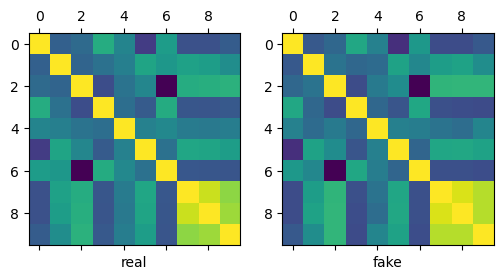

In [22]:
compare_dfs(
    data_all,
    data_generated,
    table_groupby=["T"],
    figsize=3,
)

Note the remarkable quality of the generated data.